# **TP04 - Análisis de Discriminante y Vecinos más cercanos**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/introduccion.png?raw=true" alt="tp04">
</p>


## **Exploración de datos**

<p align=center>
    <image src = "https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej1.png?raw=true" alt="exploración de datos">
</p>


---


Para obtener el dataset con el que vamos a trabajar, vamos a utilizar el comando `load_iris()` de la librería `sklearn`. Esto descarga la base de datos **Iris**, que es un diccionario que contiene varios elementos útiles para el análisis. 

Nosotros en particular nos vamos a quedar con las dos primeras columnas del atributo `iris.data` correspondientes a las dimensiones del largo y ancho del sépalo respectivamente. Tambien nos quedamos con los datos del atributo `iris.target` que contiene las etiquetas $(0, \ 1, \ 2)$ correspondientes a las especies a la que corresponde cada muestra, estas especies son: Setosa, Versicolor o Virginica respectivamente.

Una vez que tenemos los datos, vamos a dividir los conjuntos de entrenamiento y de testeo con `train_test_split` de la librería `sklearn`, en particular si queremos dividir los conjuntos de forma tal que el $70\%$ de los datos sean parte del conjunto de entrenamiento y el $30\%$ sean parte del conjunto de testeo, vamos a setear `test_size = 0.3`.


Para poder gráficar las muestras, utilizamos el método `scatter` de la librería `matplotlib`, con el cual graficamos un mapa de dispersión de las muestras.

In [201]:
#librerias
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from collections import Counter

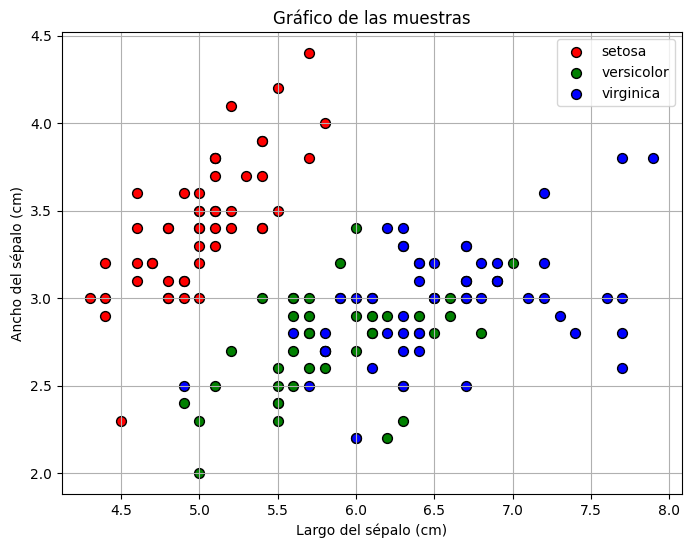

In [202]:
# Cargamos la base de datos
iris = datasets.load_iris()
X = iris.data[:, :2]  # Nos quedamos con las dos primeras columnas: largo y ancho del sépalo
y = iris.target       # etiquetas de la especie de cada muestra

# Dividimos en entrenamiento y testeo (70% entrenamiento, 30% testeo)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Grafico los datos
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
labels = iris.target_names

for i, color in enumerate(colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', s=50)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('Gráfico de las muestras')
plt.legend()
plt.grid(True)
plt.show()

A partir del gráfico de dispersión, se puede observar que las muestras de la clase Setosa se encuentran claramente separadas de las de las otras dos clases. Esto sugiere que los clasificadores no tendrán mayores dificultades para identificar correctamente a esta especie. Por otro lado, las clases Versicolor y Virginica presentan una notable superposición en el espacio de características, lo que implica que distinguir entre ellas será una tarea más desafiante para los modelos de clasificación, especialmente aquellos que se basen en fronteras lineales.

En el gráfico de dispersión se puede observar que:

- Las muestras de la clase Setosa se encuentran en una región separadas de las muestras de las demás clases. Esto sugiere que los clasificadores no deberían tener muchos problemas para identificar éstas especies.

- En cuanto a las muestras Versicolor y Virginica, se observa que las muestras de éstas dos especies presentan una superposición. Debido a ésta superpósicion, los clasificadores tendrán más dificultades para clasificar entre éstas dos especies.

---

## **Clasificación LDA**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej2.png?raw=true" alt="ejercicio LDA">
</p>

---

El Análisis Discriminante Lineal (LDA) es un modelo generativo para clasificación que asume que los datos de cada clase siguen una distribución normal multivariada con la misma matriz de covarianza, pero de medias diferentes.

Para LDA, se realizan las siguientes suposiciones:

- La variable de clase $ Y $ sigue una distribución categórica:
  $$
  Y \sim \text{Cat}(\{c_1, \cdots, c_K\})
  $$
- La variable de entrada $ X $ condicionada a la clase $ Y = k $ sigue una normal multivariada con media $ \mu_k $ y covarianza $ \Sigma $:
  $$
  X \mid Y = k \sim \mathcal{N}(\mu_k, \Sigma_k)
  $$

Este modelo, asume que $\hat{p}(x)$ es una mezcla de gaussianas, es decir, podemos expresar ésta densidad de probabilidad total de la siguiente manera:

$$
\hat{p}(x) = \sum_{k=1}^K c_k \cdot \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} e^{-\frac{1}{2} (x - \mu_k)^T \Sigma^{-1} (x - \mu_k)}
$$

donde:

- $\mu_k$ es el vector de medias para la clase $k$.
- $\Sigma$ es la matriz de covarianza común entre las clases.
- $c_k$ es la probabilidad a priori de la clase $k$. 

Nosotros queremos estimar la probabilidad $\hat{P}(y | x)$, es decir, la probabilidad de que $y$ pertenezca a la clase $k$ dado un vector de muestras $x$. Utilizando la regla de Bayes:

$$
\hat{P}(y|x) = \frac{\hat{P}(x|y) \cdot P(y)}{\hat{p}(x)}
$$

Desarrollando llegamos a la siguiente expresión:

$$
\hat{P}(y|x) = \frac{e^{\mu_y^T \Sigma^{-1} x - \frac{1}{2} \mu_y^T \Sigma^{-1} \mu_y + \log(c_y)}}{\sum_{k=1}^{K} e^{\mu_k^T \Sigma^{-1} x - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log(c_k)}}
$$

Dada la forma de $\hat{P}(y|x)$ podemos relacionarlo con la regresión logística. Si asumimos que $w_y = \Sigma^{-1} \ \mu_y$ y que $b_y = - \frac{1}{2} \ \mu_y^T \ \Sigma^{-1} \ \mu_y + \log(c_y)$, podemos decir que $\hat{P}(y|x)$ es la softmax. 

Por lo tanto, la elección del máximo queda de la siguiente manera:

$$
\arg\max_{y} \, \hat{P}(y|x) = \arg\max_{y} \, w_y^T x + b_y
$$

Esto separa las clases mediante hiperplanos.

---

### **<u>Estimadores</u>**

Para poder entrenar un clasificador LDA, es necesario estimar los parámetros del modelo: la media de cada clase, la matriz de covarianza común y las probabilidades a priori. Estos parámetros se obtienen a partir de estimadores insesgados.

Dado un conjunto de entrenamiento $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$, se define $\mathcal{D}_k$ como el subconjunto de muestras que pertenecen a la clase $k$. A partir de ahí, se calcula:

- La probabilidad a priori de la clase $k$:  
  $$
  c_k = \frac{\#\mathcal{D}_k}{n}
  $$

- El vector de medias de la clase $k$:  
  $$
  \mu_k = \frac{1}{\#\mathcal{D}_k} \sum_{x \in \mathcal{D}_k} x
  $$

- La matriz de covarianza de la clase $k$:  
  $$
  \Sigma_k = \frac{1}{\#\mathcal{D}_k - 1} \sum_{x \in \mathcal{D}_k} (x - \mu_k)(x - \mu_k)^T
  $$

- Finalmente, la matriz de covarianza común entre todas las clases (solo en LDA), se estima como:  
  $$
  \Sigma = \frac{1}{n - K} \sum_{k=1}^K (\# \mathcal{D}_k - 1)\Sigma_k
  $$

Estos estimadores permiten construir el modelo probabilístico que utiliza LDA para clasificar nuevas muestras.

---

### **<u>Implementación</u>**

Para la implementación, dado que vamos a trabajar con los modelos LDA y QDA (que presentan varias similitudes), vamos a crear una clase llamada `DiscriminantAnalysis`, que tiene un parámetro `mode`, en el cual se va a especificar si el modelo es `lda` o `qda`. Si no se le indica el modo en el cual vamos a trabajar, por default es `lda`.

### **<u>1. Entrenamiento</u>**

Siguiendo con el modelo de `LDA`, cuando aplicamos el método `fit(X, y)` para este modo, lo que se hace es calcular los parámetros mencionados previamente, es decir, a partir de las muestras $\mathbf{X}$ y las etiquetas $\mathbf{y}$, calculamos para cada clase $k$, la probabilidad a priori $c_k$, la media $\mu_k$, la matriz de covarianza $\Sigma_k$, y a partir de las matrices $\Sigma_k$, calculamos la matriz de covarianza común $\Sigma$, todo esto calculado con los estimadores insesgados mencionados con anterioridad.

### **<u>2. Etapa de testeo soft</u>**

Para la etapa de testeo soft, creamos el método `predict_proba(X)`. Este método lo que hace es calcular la probabilidad $\hat{P}(y=k|x)$ para cada muestra de X, a partir de la expresión mencionada previamente. Es decir, para cada muestra $x$ y para cada clase $k$, se calcula:

$$
\hat{P}(y=k | x) = w^T x + b = \Sigma^{-1} \mu_k^T x - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + log(c_k)
$$


De esta forma se implementa la etapa de testeo soft que calcula $\hat{P}(y=k|x)$.

### **<u>3. Etapa de testeo hard</u>**

Por último, para la etapa de testeo hard, implementamos el metodo `predict(X)`. Esto lo que hace es quedarse con el máximo de $\hat{P}(y=k|x)$ para cada muestra.

Una vez que tenemos implementado el modelo de LDA, entrenamos el mismo con los conjuntos `X_train` e `y_train` generados previamente.

---

### **<u>Gráfico de las regiones de decisión y curvas de nivel</u>**

Para poder graficar las regiones de decisión del modelo, generamos una grilla de puntos utilizando `meshgrid`. Luego, para cada punto de la grilla, predecimos la clase utilizando `predict`. Por último, con los datos de la grilla y la clase predicha para cada punto de la misma, utilizamos `contourf()` para poder graficar las regiones de decisión.

Por último, para cada clase, graficamos su media y algunas curvas de nivel. Para poder graficar las curvas de nivel, tenemos que generar una distribución normal multivariada centrada en la media de cada clase, y donde la matriz de covarianza de cada normal es la matriz de covarianza común (ya que estamos en LDA). Con `pdf()` se calcula la densidad de probabilidad de esa distribución para todos los puntos de la grilla, y luego con `countour` se grafican algunas curvas de nivel de la misma.


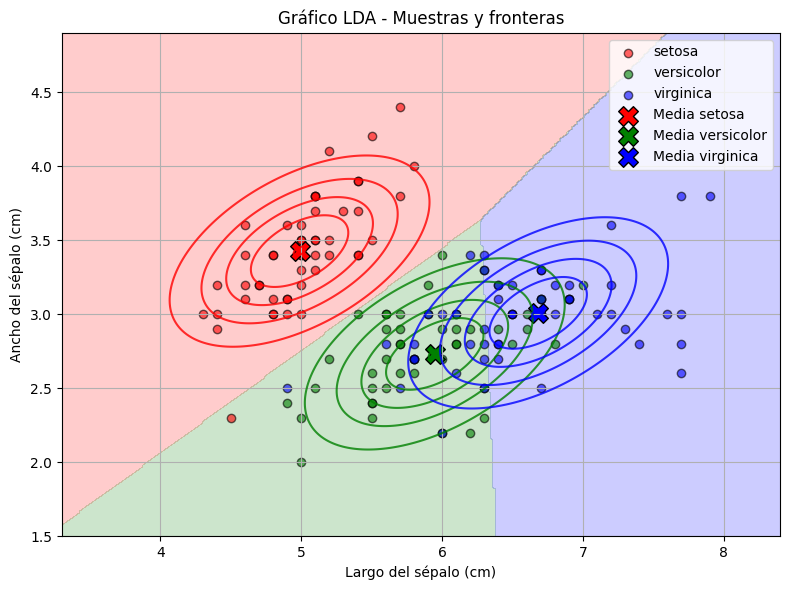

In [203]:
# ===== Clase común para LDA y QDA =====
class DiscriminantAnalysis:
    def __init__(self, mode='lda'):
        assert mode in ['lda', 'qda'] #la clase debe ser lda o qda
        self.mode = mode
        self.means_ = None
        self.covs_ = None
        self.priors_ = None
        self.classes_ = None
        self.shared_cov_ = None
        self.inv_shared_cov_ = None

    #ETAPA DE ENTRENAMIENTO
    def fit(self, X, y):
       
        self.classes_ = np.unique(y)
        n_features = X.shape[1]
        self.means_ = []
        self.covs_ = []
        self.priors_ = []
        
        #se calcula para cada clase la media, la matriz de covarianza y la probabilidad c_k
        for cls in self.classes_:
            X_cls = X[y == cls]
            mean = X_cls.mean(axis=0)
            cov = np.cov(X_cls.T)
            self.means_.append(mean)
            self.covs_.append(cov)
            self.priors_.append(len(X_cls) / len(X))

        self.means_ = np.array(self.means_)
        self.covs_ = np.array(self.covs_)
        self.priors_ = np.array(self.priors_)

        #En el caso de lda, se calcula la matriz de covarianza común
        if self.mode == 'lda':

            sum_cov = np.zeros((n_features, n_features))
            for i, cls in enumerate(self.classes_):
                X_cls = X[y == cls]
                sum_cov += (X_cls.shape[0] - 1) * self.covs_[i]
            self.shared_cov_ = sum_cov / (len(X) - len(self.classes_))
            self.inv_shared_cov_ = np.linalg.inv(self.shared_cov_)

    #ETAPA DE TESTEO SOFT
    def predict_proba(self, X):
        probs = []
        #iteramos en cada muestra
        for x in X:
            scores = []

            #iteramos sobre las clases
            for i, cls in enumerate(self.classes_):
                mean = self.means_[i]
                prior = self.priors_[i]

                #Calculo de P(y=k|x)
                if self.mode == 'lda':
                    score = self.inv_shared_cov_ @ mean @ x - 0.5 * mean.T @ self.inv_shared_cov_ @ mean + np.log(prior)
                else:  # QDA
                    cov = self.covs_[i]
                    inv_cov = np.linalg.inv(cov)
                    det_cov = np.linalg.det(cov)
                    delta = x - mean
                    score = -0.5 * delta.T @ inv_cov @ delta - 0.5 * np.log(det_cov) + np.log(prior)

                scores.append(score)

            scores = np.array(scores)
            probs.append(scores)
        return np.array(probs)

    #ETAPA DE TESTEO HARD
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# Entrenamos el modelo
lda = DiscriminantAnalysis(mode='lda')
lda.fit(X_train, y_train)

# Generamos el gráfico
colors = ['red', 'green', 'blue']
labels = iris.target_names
plt.figure(figsize=(8, 6))

# 1. Graficamos las regiones de decisión

#para ello tenemos que generar una grilla
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# obtenemos la clase a la que pertenencen los puntos de la grilla 
Z = lda.predict(grid).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors) #graficamos las regiones de decisión

# 2. Mapa de dispersión
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=labels[i], edgecolor='k', alpha=0.6)

# 3. Grafico de las curvas de nivel
for i, mean in enumerate(lda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}') #marcamos la media con una x

    #generamos la distribución normal multivariada para cada clase teniendo en cuenta que en lda tenemos matriz de covarianza comun
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

# Estética del gráfico
plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('Gráfico LDA - Muestras y fronteras')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Del gráfico podemos decir que:

- Se observan las medias y las curvas de nivel de cada especie. Dada que la matriz de covarianza es la misma en el modelo de LDA, las curvas de nivel de cada especie son similares, pero están centradas en la media de la correspondiente especie.

- Como se mencionó previamente, el modelo no presenta muchas dificultades para clasificar a la especie Setosa, ya que se observa que solo una de las muestras de ésta especie quedó en la región correspondiente a la especie Versicolor.

- En el caso de las especies Versicolor y Virginica, debido al solapamiento de las muestras, el modelo tiene más dificultad para poder separar éstas dos especies. Este solapamiento se observa tanto en las regiones de decisión como en las medias de las especies.

---

### **<u>Accuracy LDA </u>**

In [204]:
#funcion para calcular el accuaracy
def calcular_accuaracy(y_true, y_pred):
  return np.mean( (y_true == y_pred) )


# Evaluar en test
y_pred = lda.predict(X_test)
acc = calcular_accuaracy(y_test, y_pred)

print(f"Accuracy en test: {acc * 100:.2f}%")

Accuracy en test: 75.56%


---

## **Síntesis**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej3.png?raw=true" alt="enunciado Sintesis">
</p>

---

Siguiendo con el modelo de LDA, asumimos que los datos de cada clase $k$ provienen de una distribución normal multivariada $\mathcal{N}(\mu_k, \Sigma)$, donde :

- $\mu_k$ es la media de la clase $k$.
- $\Sigma$ es la matriz de covarianza común para todas las clases.

Además durante el entrenamiento del modelo LDA, el mismo aprende las probabilidades $c_k$.

Por lo tanto, para generar cada muestra sintética, procedemos de la siguiente manera:

- Primero debemos elegir aleatoriamente la clase a la que va a pertenecer la muestra. Para ello utilizamos la función `random.choice()` de `Numpy` a la que le pasamos como argumento, las clases disponibles y cuales son las probabilidades $c_k$. Esto se realiza con la siguiente linea de código:

<p align="center"><code>cls = np.random.choice(lda.classes_, p=lda.priors_)</code></p>


- Una vez que elegimos la clase a la que va a pertenecer la muestra sintética, obtenemos la matriz de covarianza común $\Sigma$ y la media $\mu_k$. Con estos datos procedemos a generar una distribución normal multivariada y nos quedamos con una muestra aleatoria de la misma. Esto se logra mediante la siguiente linea de código:

<p align="center"><code>sample = np.random.multivariate_normal(mean=lda.means_[cls], cov=cov)</code></p>

- Luego guardamos en una lista la muestra sintética obtenida y la clase a la que pertenece.


Una vez que generamos las 30 muestras sintéticas, procedemos a graficar las mismas junto con las regiones de decisión obtenidas en la etapa anterior.



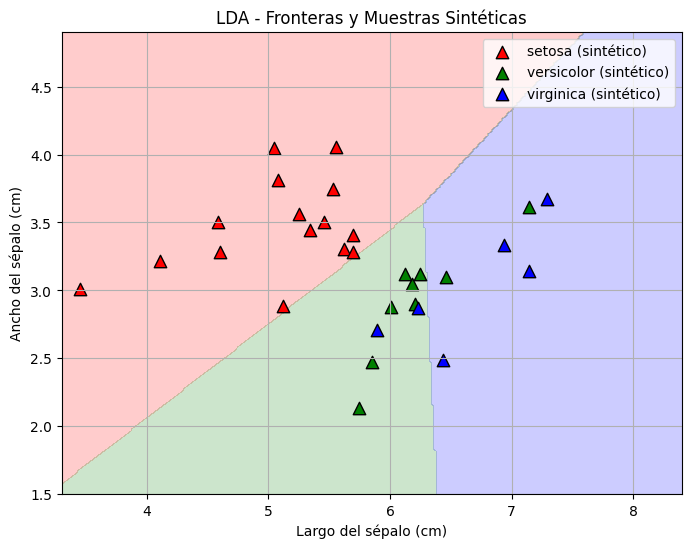

In [205]:
# === Generar 30 muestras sintéticas usando el modelo LDA ===
np.random.seed(42)
n_samples = 30
synthetic_X = []
synthetic_y = []

for _ in range(n_samples):
    # Elegir clase según prior
    cls = np.random.choice(lda.classes_, p=lda.priors_)
    
    # Muestrear desde la gaussiana correspondiente
    cov = lda.shared_cov_ if lda.mode == 'lda' else lda.covs_[i]
    sample = np.random.multivariate_normal(mean=lda.means_[cls], cov=cov)
    
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# === Gráfico con regiones + muestras sintéticas ===

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# Muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]} (sintético)', edgecolor='black', s=80)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('LDA - Fronteras y Muestras Sintéticas')
plt.legend()
plt.grid(True)
plt.show()


---

## **Discriminante Cuadrático**

<p align=center>
    <image src="https://github.com/walteraguirre/TPS/blob/main/TP04/imagenes/ej4.png?raw=true"  alt="enunciado QDA">
</p>



---


QDA, al igual que LDA, es un modelo generativo de clasificación, pero a diferencia de LDA, en este caso ya no suponemos una matriz de covarianza común entre clases sino que cada clase tiene su propia matriz de covarianza $\Sigma_k$. 

Para QDA, se realizan las siguientes suposiciones:

- La variable de clase $ Y $ sigue una distribución categórica:
  $$
  Y \sim \text{Cat}(\{c_1, \cdots, c_K\})
  $$
- La variable de entrada $ X $ condicionada a la clase $ Y = k $ sigue una normal multivariada con media $ \mu_k $ y covarianza $ \Sigma_k $:
  $$
  X \mid Y = k \sim \mathcal{N}(\mu_k, \Sigma_k)
  $$


De esta forma, la densidad de probabilidad total de x es una mezcla de gaussianas, que se puede expresar de la siguiente manera:

$$
\hat{p}(x) = \sum_{k=1}^{K} c_k \cdot \frac{e^{- \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)}}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}
$$



Con todas estas suposiciones, queremos estimar la probabilidad $\hat{P}(y|x)$, cuya expresión es la siguiente:

$$
\hat{P}(y|x) = \frac{e^{- \frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y) + \log(c_y) - \frac{1}{2} \log |\Sigma_y|} }{\sum_{k=1}^{K} e^{- \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k)+ \log(c_k) - \frac{1}{2} \log |\Sigma_k|} }
$$


Para predecir la clase más probable, se elige aquella que maximiza:

$$
\arg\max_y \left[ -\frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y) + \log(c_y) - \frac{1}{2} \log |\Sigma_y| \right]
$$


 A diferencia de LDA, la frontera de decisión no es lineal, sino cuadrática, debido a que cada clase tiene su propia matriz de covarianza.

 --- 

 ## **Implementación**

 Como se mencionó previamente, como los modelos LDA y QDA presentan similitudes, se generó una clase `DiscriminantAnalysis` donde se puede configurar el parámetro `mode` para poder elegir entre `lda` o `qda`. En este caso nos interesa analizar la implmentación de las etapas de entrenamiento y de testeo del modelo `QDA`.

 Para la etapa de entrenamiento, tenemos el método `fit(X, y)`, que al igual que en LDA, a partir de las muestras $\mathbf{X}$ y las etiquetas $\mathbf{y}$, se calcula para cada clase, la media $\mu_k$, la matriz de covarianza $\Sigma_k$ y las probabilidades $c_k$. La diferencia en este caso con LDA, es que no hace falta calcular la matriz de covarianza común, ya que cada clase tiene su propia matriz de covarianza.


Para la etapa de testeo soft, implementamos la función `predict_proba(X)`, donde queremos calcular $\hat{P}(y|x)$. Para ello, para cada muestra de $\mathbf{X}$ y para cada clase $k$, calculamos:

$$
\left[- \frac{1}{2} (x - \mu_y)^T \Sigma_y^{-1} (x - \mu_y) + \log(c_y) - \frac{1}{2} \log |\Sigma_y| \right]
$$

Recalcamos nuevamente que para este caso, las matrices de covarianza utilizada para los calculos serán diferentes para cada clase $k$. 


Luego para la etapa de testeo hard, implementamos la función `predict(X)`, donde a partir de las probabilidades obtenidas mediante `predict_proba`, nos quedamos con la clase que tiene mayor probabilidad para cada muestra.




Accuracy QDA en test: 71.11%


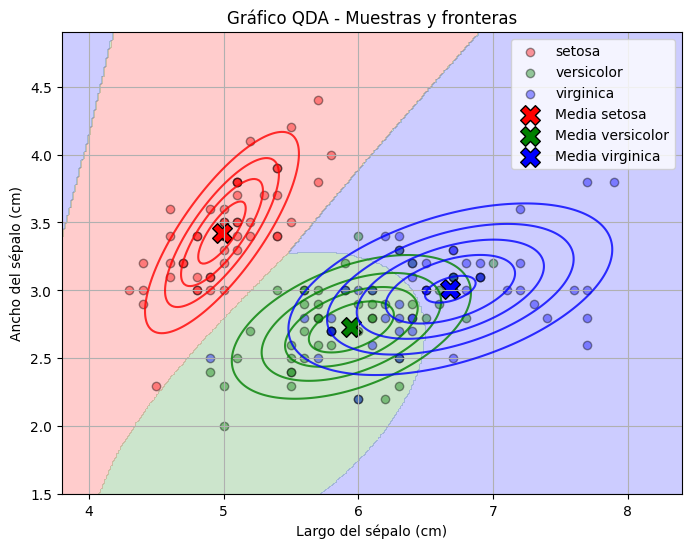

In [206]:
#entrenamos el modelo 
qda = DiscriminantAnalysis(mode='qda')
qda.fit(X_train, y_train)

# calculamos el accuaracy del modelo
y_pred_qda = qda.predict(X_test)
acc_qda = calcular_accuaracy(y_test, y_pred_qda)
print(f"Accuracy QDA en test: {acc_qda * 100:.2f}%")

rv = multivariate_normal(mean=mean, cov=qda.covs_[i])  # en vez de shared_cov_


# 1-Grafico de las regiones de decisión

#generamos la grilla 
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = qda.predict(grid).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# 2- graficamos las muestras con scatter
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]}', edgecolor='k', alpha=0.4)

# 3- graficamos las medias y las curvas de nivel para cada especie
for i, mean in enumerate(qda.means_):
    plt.scatter(*mean, c=colors[i], s=200, marker='X', edgecolor='black', label=f'Media {labels[i]}')
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[i]
    rv = multivariate_normal(mean=mean, cov=cov)
    zz = rv.pdf(grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=5, colors=colors[i], alpha=0.8)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'Gráfico QDA - Muestras y fronteras')
plt.legend()
plt.grid(True)
plt.show()



A partir del gráfico podemos notar lo siguiente:

- A diferencia de LDA, en este caso las matrices de covarianza para cada especie son diferentes, por lo tanto, ahora las curvas de nivel no van a ser similares, sino que ahora tienen formas y orientaciones diferentes para cada especie.

- Ahora las fronteras de decisión no son rectas como en LDA, sino que son curvas.

- Al igual que en LDA, la especie Setosa, sigue siendo facil de separar, y en este caso todas las muestras quedan dentro de la correspondiente región.

- Con respecto a las otras dos especies, es inevitable la superposición.

En cuanto a la precisión del modelo, en este caso disminuyó con respecto al modelo LDA. 

---

Para obtener las muestras sinteticas se procede de manera similar a la generación de muestras sintéticas en LDA. Es decir:

- Primero se elige la clase a la que va a pertenecer la muestra. Para ello utilizamos `random.choice()` de Numpy, pasando como argumento las clases de Iris y las prioridades $c_k$ de cada clase.

- Luego de elegir la clase de la muestra, procedemos a generar una muestra aleatoria de una normal multivariada teniendo en cuenta la media $\mu_k$ y la matriz de covarianza para dicha clase $\Sigma_k$.

Por último, una vez que tenemos todas las muestras, se procede a graficarlas junto con las regiones de decisión obtenidas. 

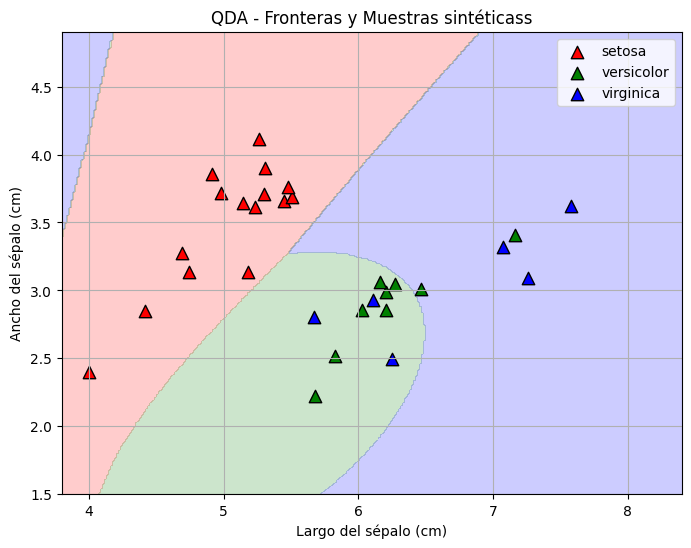

In [207]:
# ===== Generar muestras sintéticas =====
np.random.seed(42)
synthetic_X = []
synthetic_y = []


for _ in range(n_samples):

    #elegimos aleatoriamente la clase
    cls = np.random.choice(qda.classes_, p=qda.priors_)

    #una vez que tenemos la clase, obtenemos una muestra de su correspondiente normal multivariada
    mean = qda.means_[cls]
    cov = qda.shared_cov_ if qda.mode == 'lda' else qda.covs_[cls]
    sample = np.random.multivariate_normal(mean, cov)
    synthetic_X.append(sample)
    synthetic_y.append(cls)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# graficamos las regiones de decision
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=np.arange(len(qda.classes_) + 1) - 0.5, colors=colors, alpha=0.2)

# graficamos las muestras sintéticas
for i, color in enumerate(colors):
    idx = synthetic_y == i
    plt.scatter(synthetic_X[idx, 0], synthetic_X[idx, 1], c=color, marker='^',
                label=f'{labels[i]}', edgecolor='black', s=80)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title(f'{qda.mode.upper()} - Fronteras y Muestras sintéticass')
plt.legend()
plt.grid(True)
plt.show()


## **KNN**

K-Nearest Neighbour (KNN) es un modelo de clasificación no parámetrico, es decir, que no asume una estructura a priori para la distribución, a diferencia de los modelos vistos previamente como LDA y QDA. KNN no requiere estimar parámetros: lo único que necesita para clasificar nuevos datos es almacenar el conjunto de entrenamiento.

---

## **Implementación**

Para poder implementar este modelo se genera una clase `KNN` que recibe como parámetro la cantidad de vecinos $k$, en este caso, seteamos como valor default `k=6`. 

### **<u> Entrenamiento </u>**

Como se dijo con anterioridad, para el entrenamiento, se implementa el método `fit(X, y)`, que lo unico que hace es almacenar las muestras de $\mathbf{X}$ y las etiquetas $\mathbf{y}$ para cada clase. 

### **<u> Etapa de testeo soft </u>**

Para ésta etapa se implementa el método `predict_proba(X)` que estima $\hat{P}(y|x)$ , es decir, la probabilidad de que una muestra $x$ pertenezca a la clase $y$. Para ello el método, para cada muestra, opera de la siguiente manera:

- Primero se calcula la distancia euclidea entre la muestra $\mathbf{x}$ y todas las muestras del conjunto de entrenamiento $\mathbf{X_{train}}$, es decir, se realiza la siguiente operación:

$$
d(\mathbf{x}, \mathbf{x_i}) = ||\mathbf{x} - \mathbf{x_i}||_2
$$

- Luego, nos quedamos con los $k$ vecinos más cercanos.

- Por último lo que se hace es calcular las probabilidades de que la muestra $x$ pertenezca a la clase $y$, esto se logra facilmente con la siguiente operación:

$$
\hat{P}(y|x) = \frac{K_y}{K}
$$

donde:

- $K_y$ es la cantidad de muestras (dentro de las K muestras con las que nos quedamos) que pertenecen a la clase $y$.
- $K$ es un valor que fijamos nosotros para la cantidad de vecinos a considerar.


### **<u>Etapa de testeo hard</u>**

Se implementa el método `predict(X)`, que lo único que hace es, para cada muestra, quedarse con la clase que tiene la mayor probabilidad $\hat{P}(y|x)$ obtenida en la etapa de testeo soft.




Accuracy KNN (k=6) en test: 84.44%


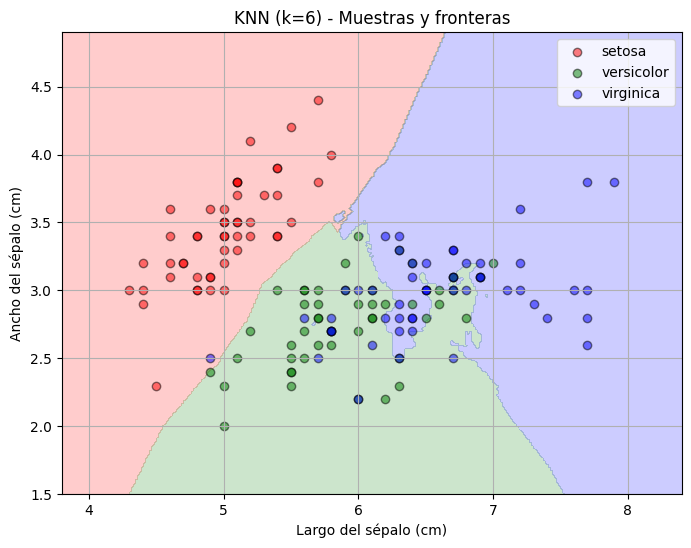

In [208]:
# generamos la clase KNN
class KNN:
    def __init__(self, k=6):
        self.k = k
        self.X_train = None
        self.y_train = None

    #Etapa de entrenamiento
    def fit(self, X, y):
        #solo guardamos los datos
        self.X_train = X
        self.y_train = y

    #Etapa de testeo soft
    def predict_proba(self, X):
        probs = []
        for x in X:
            #calculamos las distancias 
            dists = np.linalg.norm(self.X_train - x, axis=1)

            #nos quedamos con los 6 mas cercanos
            knn_indices = np.argsort(dists)[:self.k]
            knn_labels = self.y_train[knn_indices]
            counts = Counter(knn_labels)

            #calculamos las probilidades
            prob = np.array([counts.get(cls, 0) / self.k for cls in np.unique(self.y_train)])
            probs.append(prob)
        return np.array(probs)

    #Etapa de testeo hard
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
# Entrenamos el modelo
knn = KNN(k=6)
knn.fit(X_train, y_train)

# calculamos el accuaracy
y_pred_knn = knn.predict(X_test)
acc_knn = calcular_accuaracy(y_test, y_pred_knn)
print(f"Accuracy KNN (k=6) en test: {acc_knn * 100:.2f}%")

# Grafico 

# generamos la grilla de puntos
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = knn.predict(grid).reshape(xx.shape)

#graficamos las regiones de decision
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(len(lda.classes_) + 1) - 0.5, colors=colors)

# graficamos las muestras
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=f'{labels[i]}', edgecolor='k', alpha=0.5)

plt.xlabel('Largo del sépalo (cm)')
plt.ylabel('Ancho del sépalo (cm)')
plt.title('KNN (k=6) - Muestras y fronteras')
plt.legend()
plt.grid(True)
plt.show()



Del grafico podemos observar:

- A diferencia de LDA (que genera fronteras lineales) y de QDA (que genera fronteras cuadraticas), KNN crea fronteras no lineales que se adaptan a la distribución de datos, esto se puede ver especificamente en la frontera entre la especie Versicolor y Virginica, que los modelos anteriores, debido al solapamiento entre muestras, no podian clasificar bien estas dos especies.

- Si bien todavia hay solapamiento entre la especie Virginica y Versicolor, con este método y con la caracteristica de poder obtener fronteras altamente no lineales, la precisión aumentó con respecto a los 2 modelos anteriores.